# Question

Is there an easy way to merge circuits, so take 3 pregenerated circuits and merge them to one big one?

In [289]:
import numpy as np
import matplotlib.pyplot as plt
import pymatching
import stim

# 1. Try for steane typ QEC code

Using a surface 17 code of distance 3.

## Basic plan. 

1. initalize 3 logical qubits, $\ket{\Psi}_L$, $\ket{0}_L$, $\ket{+}_L$
    + We use surface 17 circuits with distance 3
2. test implementation of surface 17 code! (works !!)
    + compared to previous solutions and returned same results
3. add measurement of the auxillary qubits!
4. add encoding  (Fix)
5. work out the error ?! 


## Questions

In [335]:
# Stabilizers for the 3 distance surface17 code
Z_stabilizers = [
    [1,0,0,1,0,0,0,0,0],
    [0,0,0,1,1,0,1,1,0],
    [0,1,1,0,1,1,0,0,0],
    [0,0,0,0,0,1,0,0,1]
    ]
X_stabilizers = [
    [0,1,1,0,0,0,0,0,0],
    [1,1,0,1,1,0,0,0,0],
    [0,0,0,0,1,1,0,1,1],
    [0,0,0,0,0,0,1,1,0]
    ]

def generate_qubit_indices(index_unused_qubit: int,stabilizer_on_aux=True):
    """
    We are starting from the last used qubit and generate the indices of:
    9 data qubits 
    4 Z measure qubits
    4 X measure qubits
    and returns those as a dict
    """
    data_qubits = np.arange(index_unused_qubit,index_unused_qubit + 9)
    index_unused_qubit += 9
    log_qubit_indices = {
        "data": data_qubits,
        }
    if stabilizer_on_aux:
        Z_measure_qubits = np.arange(index_unused_qubit,index_unused_qubit + 4)
        index_unused_qubit += 4
        X_measure_qubits = np.arange(index_unused_qubit,index_unused_qubit + 4)
        index_unused_qubit += 4
        log_qubit_indices.update({ 
            "Z_measure": Z_measure_qubits,
            "X_measure": X_measure_qubits,
        })
    return index_unused_qubit, log_qubit_indices 

def add_stabilizer(circuit,log_qubit_indices):
    """
    Adds a surface 17 stabilizer qubit to the circuit, with the given qubits
    """
    data_qubits = log_qubit_indices["data"]
    Z_measure_qubits = log_qubit_indices["Z_measure"]
    X_measure_qubits = log_qubit_indices["X_measure"]

    # Z stabilizers: C(data)NOT(measure)
    for i,stabilizer in enumerate(Z_stabilizers):
        for j in np.argwhere(np.array(stabilizer)[:] == 1).ravel():
            # CxNOTy (of the list) "CNOT",[x,y]
            circuit.append("CNOT",[data_qubits[j],Z_measure_qubits[i]])
    circuit.append("MR", Z_measure_qubits)

    # for i in range(4):
        # circuit.append("DETECTOR",[stim.target_rec(-(i+1))])
    circuit.append("TICK")

    # X stabilizers: H(measure) C(measure)NOT(data) H(measure)
    circuit.append("H",X_measure_qubits)
    circuit.append("TICK")
    for i,stabilizer in enumerate(X_stabilizers):
        for j in np.argwhere(np.array(stabilizer)[:] == 1).ravel():
            circuit.append("CNOT",[X_measure_qubits[i],data_qubits[j]])
    circuit.append("TICK")
    circuit.append("H",X_measure_qubits)
    circuit.append("TICK")
    circuit.append("MR", X_measure_qubits)
    # for i in range(4):
        # circuit.append("DETECTOR",[stim.target_rec(-(i+1))])
    circuit.append("TICK")
    return circuit


In [359]:
def gen_steane_circuit(noise,
                       surface_code=False,
                       aux_p_qubit_used=True,
                       aux_0_qubit_used=True,
                       X_detectors_active=True,
                       stabilizer_on_aux=False,
                       X_errors=False,
                       Z_errors=False,
                       ):
    if surface_code:
        aux_0_qubit_used = False
        aux_p_qubit_used = False
    # surface_code = True if I just want to simulate a surface 17 code
    steane_circuit = stim.Circuit()
    index_unused_qubit = 0 
    # generate indices & initialize qubits
    index_unused_qubit, general_qubit = generate_qubit_indices(index_unused_qubit)
    steane_circuit = add_stabilizer(steane_circuit, general_qubit)
    if aux_0_qubit_used:
        index_unused_qubit, aux_0_qubit = generate_qubit_indices(index_unused_qubit)
        steane_circuit = add_stabilizer(steane_circuit, aux_0_qubit)
    if aux_p_qubit_used:
        index_unused_qubit, aux_p_qubit = generate_qubit_indices(index_unused_qubit)
        steane_circuit = add_stabilizer(steane_circuit, aux_p_qubit)
        steane_circuit.append("H",aux_p_qubit["data"]) # initalize in |+>-state
        steane_circuit.append("TICK")

    # set of errors 
    p = noise
    if aux_0_qubit_used or Z_errors:
        steane_circuit.append("Z_ERROR",general_qubit["data"],p)
    if aux_p_qubit_used or X_errors:
        steane_circuit.append("X_ERROR",general_qubit["data"],p)
    steane_circuit.append("TICK")

    # steane entanglement
    for key in ["data"]:
        for i, _ in enumerate(general_qubit[key]):
            if aux_0_qubit_used:
                steane_circuit.append("CNOT",[aux_0_qubit[key][i],general_qubit[key][i]])
    for key in ["data"]:
        for i, _ in enumerate(general_qubit[key]):
            if aux_p_qubit_used:
                steane_circuit.append("CNOT",[general_qubit[key][i],aux_p_qubit[key][i]])
    steane_circuit.append("TICK")

    # second set of stabilizers
    steane_circuit = add_stabilizer(steane_circuit, general_qubit)
    # TODO: following one is hardcoded...
    for i in range(4):
        previous_measurement = 8 * aux_0_qubit_used + 8 * aux_p_qubit_used + 8 
        index_old_measurement = - (i + 1 + previous_measurement)
        index_new_measurement = - (i +1)
        steane_circuit.append("DETECTOR",[stim.target_rec(index_old_measurement),stim.target_rec(index_new_measurement)])
    
    if stabilizer_on_aux: # we do not want to correct the errors on those qubits! 
        if aux_0_qubit_used:
            steane_circuit = add_stabilizer(steane_circuit, aux_0_qubit)
        if aux_p_qubit_used:
            steane_circuit.append("H",aux_p_qubit["data"]) # initalize in |+>-state
            steane_circuit = add_stabilizer(steane_circuit, aux_p_qubit)

    # measure ancilla qubits
    if aux_0_qubit_used:
        steane_circuit.append("H",aux_0_qubit["data"])
        steane_circuit.append("MR",aux_0_qubit["data"])
        for i in range(len(aux_0_qubit["data"])):
            steane_circuit.append("DETECTOR",[stim.target_rec(-(i+1))])
    if aux_p_qubit_used:
        steane_circuit.append("MR",aux_p_qubit["data"])
        for i in range(len(aux_p_qubit["data"])):
            steane_circuit.append("DETECTOR",[stim.target_rec(-(i+1))])
    steane_circuit.append("TICK")

    # measure general qubit
    steane_circuit.append("M",general_qubit["data"])
    steane_circuit.append("OBSERVABLE_INCLUDE",[stim.target_rec(-(i+1)) for i in range(9)],0)

    return steane_circuit

steane_circuit = gen_steane_circuit(0,
                                    aux_0_qubit_used=True,
                                    aux_p_qubit_used=True,
                                    )
steane_circuit.diagram("timeline-svg")

if 1:
    diagram = steane_circuit.diagram("timeline-svg")  
    with open('my_circuit.svg', 'w') as f:
        f.write(str(diagram))

In [433]:
sampler = steane_circuit.compile_sampler()
for j, one_shot in enumerate(sampler.sample(shots=1)):
    print(one_shot)

    offset_stabilizer = 24 
    print("PSI: Z stabilizers")
    for i in range(4):
        print(one_shot[i],one_shot[i+offset_stabilizer])
    print("PSI: X stabilizers:")
    for i in range(4,8):
        print(one_shot[i],one_shot[i+offset_stabilizer])

    print("Aux qubits stabilizer:")
    for i in range(8,24):
        if i%8==0:
            print("Z stabilizers")
        elif i%4==0:
            print("X stabilizers")
        print(one_shot[i])

    print("Aux 0 measurement", np.sum(one_shot[32:41])%2)
    for i in range(32,41):
        print(one_shot[i])
    print("Aux + measurement", np.sum(one_shot[41:50])%2)
    for i in range(41,50):
        print(one_shot[i])
    
    print("Proper Measurement",np.sum(one_shot[50:59])%2)
    for i in range(50,59):
        print(one_shot[i])
    


[False False False False  True  True False  True False False False False
  True  True  True  True False False False False False False  True False
 False False False False  True  True  True  True  True False False False
  True  True False False  True  True False False False  True  True False
 False False False  True  True False  True  True  True False  True]
PSI: Z stabilizers
False False
False False
False False
False False
PSI: X stabilizers:
True True
True True
False True
True True
Aux qubits stabilizer:
Z stabilizers
False
False
False
False
X stabilizers
True
True
True
True
Z stabilizers
False
False
False
False
X stabilizers
False
False
True
False
Aux 0 measurement 0
True
False
False
False
True
True
False
False
True
Aux + measurement 1
True
False
False
False
True
True
False
False
False
Proper Measurement 0
False
True
True
False
True
True
True
False
True


In [360]:
sampler = steane_circuit.compile_detector_sampler()
print(sampler.sample(shots=10))

[[False  True  True False  True False  True False  True False  True False
   True False  True  True False  True False False False False]
 [False False False False False False  True  True  True  True  True  True
   True False False False False False False False  True False]
 [False  True  True False False False False False False False  True False
  False  True  True  True False False  True  True  True False]
 [False  True  True  True False  True False False False False False  True
   True  True  True False  True  True  True  True  True  True]
 [False False False  True  True  True False  True  True  True False False
   True False False False  True False  True False False  True]
 [ True  True False  True  True False  True False  True False  True  True
  False  True  True  True  True  True  True  True False  True]
 [ True False False False False False  True  True False False  True  True
  False  True False  True  True  True  True False  True False]
 [False False False False False False  Tr

In [352]:
dem = steane_circuit.detector_error_model()
print(repr(dem))

ValueError: The circuit contains non-deterministic detectors.

To make an SVG picture of the problem, you can use the python API like this:
    your_circuit.diagram('detslice-with-ops-svg', tick=range(0, 5), filter_coords=['D12', ])
or the command line API like this:
    stim diagram --in your_circuit_file.stim --type detslice-with-ops-svg --tick 0:5 --filter_coords D12 > output_image.svg

This was discovered while analyzing qubit initialization into |0> at the start of the circuit on:
    qubit 0

The collapse anti-commuted with these detectors/observables:
    D12

The backward-propagating error sensitivity for D12 was:
    X0
    X9
    X17
    X26

In [ ]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [ ]:
num_shots = 100_000
num_logical_errors = count_logical_errors(steane_circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 1528 wrong predictions (logical errors) out of 100000 shots


In [ ]:

num_shots = 10_000
#for circuit in [gen_steane_circuit(1)]:
if 1:
    xs = []
    ys = []
    for noise in np.linspace(0,0.15):
        circuit = gen_steane_circuit(
            noise,
            aux_0_qubit_used=True,
            aux_p_qubit_used=False, 
            )
        diagram = circuit.diagram('timeline-svg')
        with open('problem.svg', 'w') as f:
            f.write(str(diagram))
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        xs.append(noise)
        ys.append(num_errors_sampled / num_shots)
        plt.plot(xs,ys)
#plt.loglog()
plt.plot(np.linspace(0,0.15),np.linspace(0,0.15))
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.legend()
plt.show()

ValueError: The circuit contains non-deterministic detectors.

To make an SVG picture of the problem, you can use the python API like this:
    your_circuit.diagram('detslice-with-ops-svg', tick=range(0, 5), filter_coords=['D20', ])
or the command line API like this:
    stim diagram --in your_circuit_file.stim --type detslice-with-ops-svg --tick 0:5 --filter_coords D20 > output_image.svg

This was discovered while analyzing qubit initialization into |0> at the start of the circuit on:
    qubit 0

The collapse anti-commuted with these detectors/observables:
    D20

The backward-propagating error sensitivity for D20 was:
    X0
    X9
    X17

stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    R 1 3 5 8 10 12 15 17 19 2 9 11 13 14 16 18 25
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    TICK
    X_ERROR(0.01) 2 9 11 13 14 16 18 25
    MR 2 9 11 13 14 16 18 25
    DETECTOR(0, 4, 0) rec[-4]
    DETECTOR(2, 2, 0) rec[-7]
    DETECTOR(4, 4, 0) rec[-2]
    DETECTOR(6, 2, 0) rec[-5]
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11

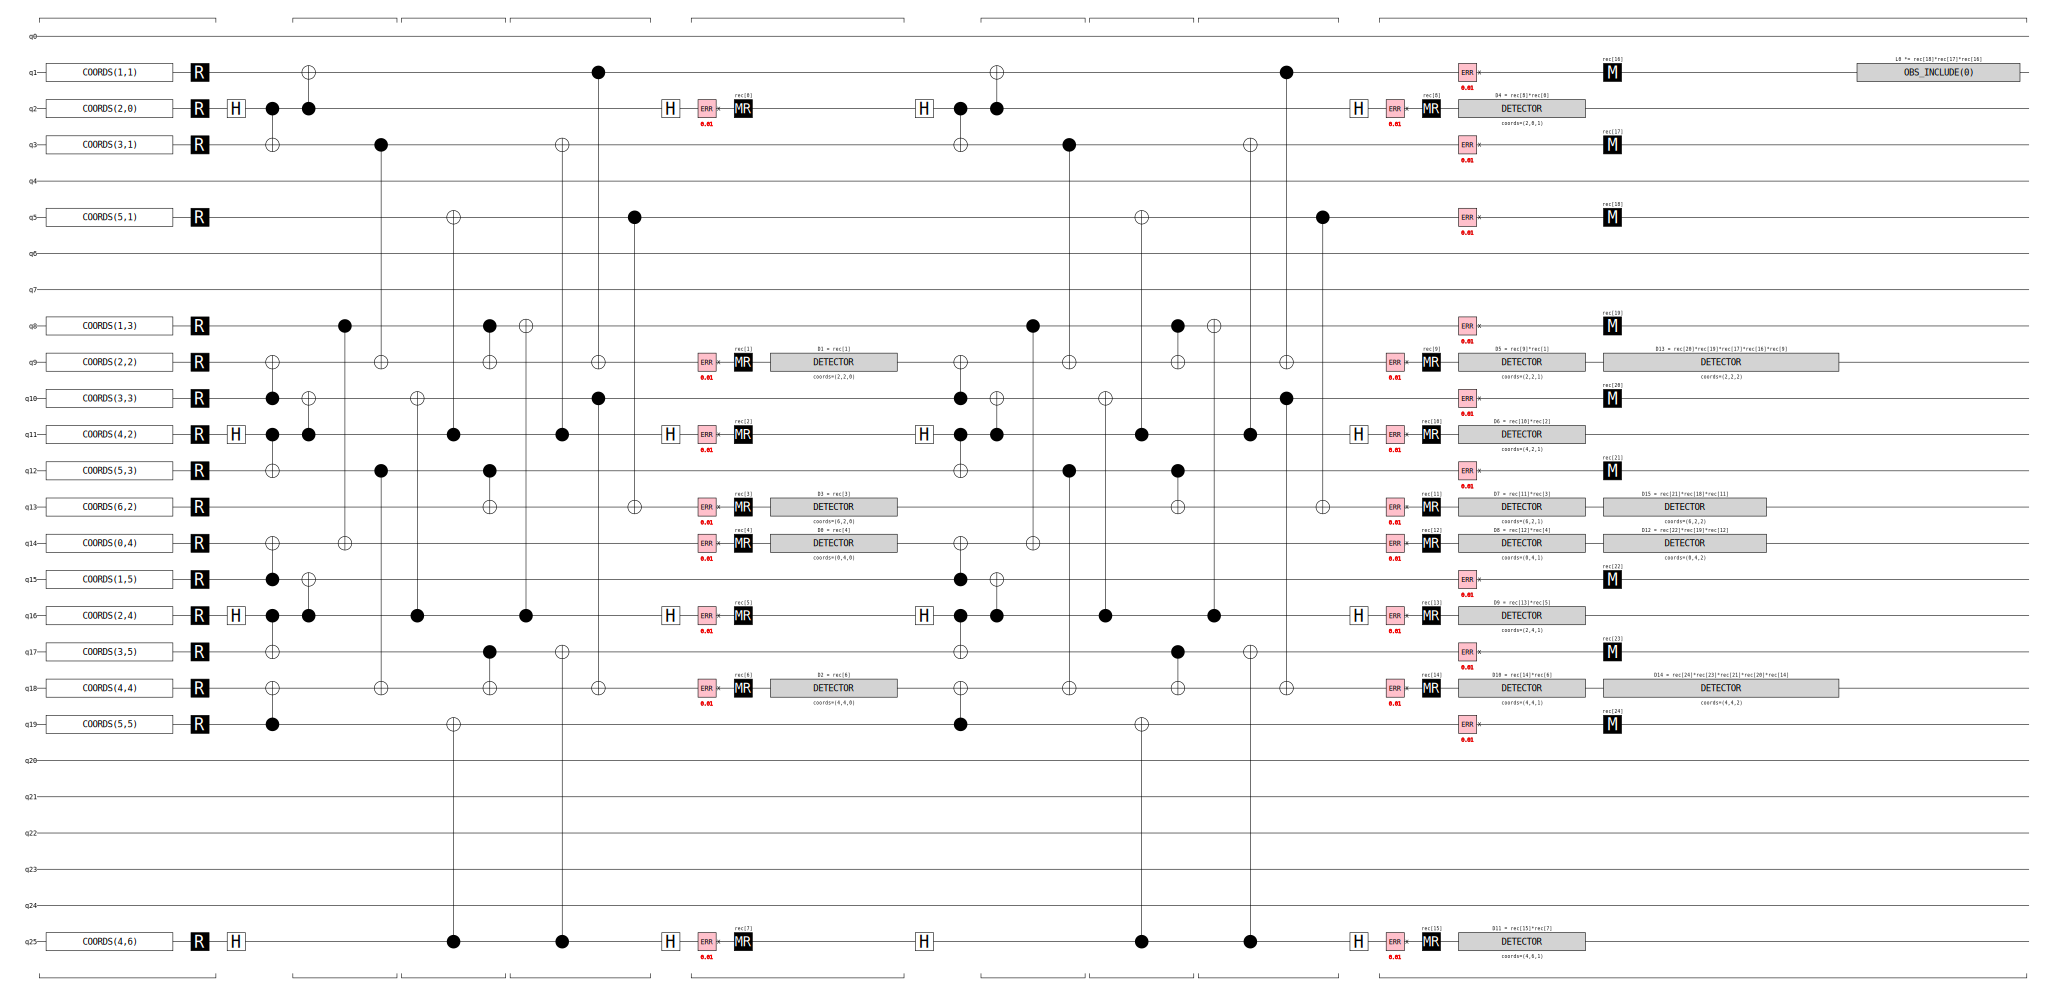

In [ ]:
circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=2,
    distance=3,
    before_measure_flip_probability=0.01)

print(repr(circuit))
circuit.diagram('timeline-svg')